In [1]:
import torch

In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
import pandas as pd
import seaborn as sns

In [5]:
df=pd.read_csv("malicious_phish.csv")

<Axes: xlabel='type', ylabel='count'>

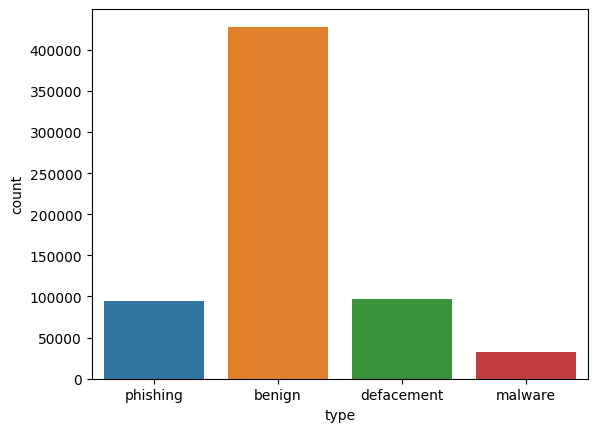

In [6]:
sns.countplot(data=df,x="type")

In [7]:
def output(x):
  if x=="benign":
    return 0
  elif x=="phishing":
    return 1
  elif x=="defacement":
    return 2
  elif x=="malware":
    return 3
df["output"]=df["type"].apply(output)

In [8]:
df=df.drop("type",axis=1)

# Splitting data into training set and testing set.
# Further splitting them into batches

In [36]:
import numpy as np

shuffled_df = df.sample(frac=1, random_state=42)
train_ratio=0.8
split_idx = int(len(shuffled_df) * train_ratio)
train_data = shuffled_df[:split_idx]
test_data = shuffled_df[split_idx:]

batch_size=1000
num_batches = len(train_data) // batch_size
train_batches = np.array_split(train_data, num_batches)



# Vectorizing a sample of the training data

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
sample=train_data["url"].sample(random_state=101,n=20000)
vectorizer.fit(sample)
input_shape=vectorizer.transform(["http://gmail.com"]).shape[1]

In [ ]:
from torch import nn
class ClassificationModel0(nn.Module):
  def __init__(self,input_shape:int,output_shape:int,hidden_units:int):
    super().__init__()
    self.layers=nn.Sequential(nn.Linear(in_features=input_shape,out_features=hidden_units),
                  nn.ReLU(),
                  nn.Linear(in_features=hidden_units,out_features=hidden_units),
                  nn.ReLU(),
                  nn.Linear(in_features=hidden_units,out_features=output_shape))
  def forward(self,x):
    return self.layers(x)
model0=ClassificationModel0(input_shape=input_shape,output_shape=4,hidden_units=10).to(device)

In [12]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model0.parameters(),lr=0.001)

In [13]:
for epoch in range(3):
  for batch in train_batches:
    data=torch.from_numpy(vectorizer.transform(batch["url"]).toarray()).to(torch.float32).to(device)

    target=torch.from_numpy(batch["output"].to_numpy()).to(torch.int64).to(device)
    model0.train()
    y_pred=model0(data).to(torch.float32).to(device)
    loss=loss_fn(y_pred,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [14]:
batch1=train_batches[1]

In [23]:
data=torch.from_numpy(vectorizer.transform(batch1["url"]).toarray()).to(torch.float32).to(device)
target=torch.from_numpy(batch1["output"].to_numpy())

In [16]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [26]:
y_pred=model0(data).argmax(dim=1).to("cpu")

In [29]:
with torch.inference_mode():
  print(accuracy_score(y_true=target,y_pred=y_pred))

0.9590818363273453


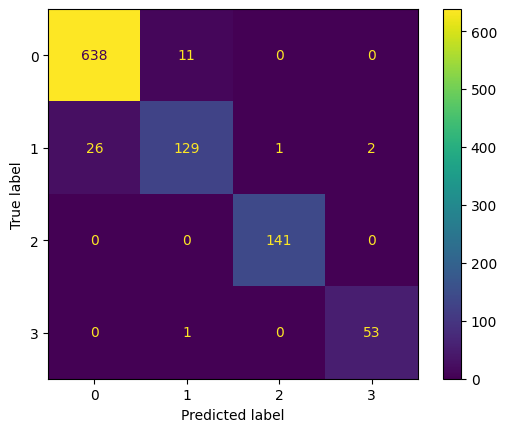

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_true=target,y_pred=y_pred)).plot()

In [37]:
batch_size=1000
num_batches_test = len(test_data) // batch_size
test_batches = np.array_split(test_data, num_batches_test)
accuracy_test=accuracy_train=0

In [39]:
with torch.inference_mode():
  for batch in test_batches:
    data=torch.from_numpy(vectorizer.transform(batch["url"]).toarray()).to(torch.float32).to(device)
    target=torch.from_numpy(batch["output"].to_numpy())
    y_pred=model0(data).argmax(dim=1).to("cpu")
    accuracy_test+=accuracy_score(y_pred=y_pred,y_true=target)



In [38]:
with torch.inference_mode():
  for batch in train_batches:
    data=torch.from_numpy(vectorizer.transform(batch["url"]).toarray()).to(torch.float32).to(device)
    target=torch.from_numpy(batch["output"].to_numpy())
    y_pred=model0(data).argmax(dim=1).to("cpu")
    accuracy_train+=accuracy_score(y_pred=y_pred,y_true=target)

In [40]:
print(f"Accuracy score on seen data | {accuracy_train/num_batches}")
print(f"Accuracy score on unseen data | {accuracy_test/num_batches_test}")

Accuracy score on seen data | 0.9536121582240901
Accuracy score on unseen data | 0.9475652169111403
